# Creating a Fitness Function

## Import Modules

In [1]:
# Import Python Mobules
import os, json, time, argparse
import numpy as np
from sys import argv
import tensorflow as tf
import tensorflow.keras as keras

# Reduce warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Basic information 1
print("Modules: Imported")

Modules: Imported


## Define Command Line Arguments

In [3]:
# Command line arguments

buildEnv = False

parser = argparse.ArgumentParser()
parser.add_argument( '-runName', )
parser.add_argument( '-modelLoc', )
parser.add_argument( "-tid",      default = '587722984435351614',  type=str )
parser.add_argument( "-start",    default = 0,  type=int, )
parser.add_argument( "-stop",     default = 3,  type=int, )
parser.add_argument( "-verbose",  default = 1,  type=int, )
parser.add_argument( "-num_epochs",    default=2,       type=int )
parser.add_argument( "-learning_rate", default=0.0001,  type=float )
parser.add_argument( "-batch_size",    default=16,      type=int )
parser.add_argument( "-save_model",    default='False', type=str )
parser.add_argument( "-data_gen",      default='True',  type=str )

# Core Model types
parser.add_argument( "-model",   default = 'efficientNetB0', type=str)
parser.add_argument( "-pool",    default = 'None',           type=str )
parser.add_argument( "-weights", default = 'imagenet',       type=str )

# Final layers
parser.add_argument( "-f_depth", default = 8,  type=int )
parser.add_argument( "-f_width", default = 32, type=int )
parser.add_argument( "-f_activation", default = 'relu', type=str )
parser.add_argument( "-output_activation", default = 'sigmoid' )

print("Args: Defined")

Args: Defined


## Establish if Building Environment or Script
Notice if code can see it's in a Jupyter Notebook Environment, it can create an artificial string of command line arguments.  This is convenient for testing the code in a Jupyter Notebook directly and changing variables on the fly.  Then when the Notebook is compiled as a python script, all changes can be stored.

In [4]:

# Am I in a jupyter notebook?
try:
    get_ipython().__class__.__name__
    buildEnv = True
    print("In Build")
    
    # Build Command Line Arguments
    cmdStr = ''
    cmdStr += ' -runName test-datagen'
    cmdStr += ' -start 1'
    cmdStr += ' -stop 3'
    cmdStr += ' -num_epochs 50'
    cmdStr += ' -learning_rate 0.0001'
    cmdStr += ' -pool None'
    cmdStr += ' -verbose 1'
    cmdStr += ' -save_model False'
    cmdStr += ' -f_depth 8'
    cmdStr += ' -f_width 32'
    cmdStr += ' -f_activation relu'
    cmdStr += ' -output_activation sigmoid'
    cmdStr += ' -model efficientNetB0'
    cmdStr += ' -data_gen False'
    
    # Read string as if command line
    args = parser.parse_args(cmdStr.split())


# Or am I in a python script?
except:
    
    # Read CMD arguments
    args = parser.parse_args()
    
    # Check for valid runName
    print( 'runName: ', args.runName )
    if args.runName == None:
        print("WARNING:  runName required")
        exit()

# Preprocess some cmd args
if args.save_model == 'True': args.save_model = True 
else:  args.save_model = False

if args.data_gen == 'True': args.data_gen = True 
else:  args.data_gen = False


print("Args: Read")
print( args )

In Build
Args: Read
Namespace(runName='test-datagen', modelLoc=None, tid='587722984435351614', start=1, stop=3, verbose=1, num_epochs=50, learning_rate=0.0001, batch_size=16, save_model=False, data_gen=False, model='efficientNetB0', pool='None', weights='imagenet', f_depth=8, f_width=32, f_activation='relu', output_activation='sigmoid')


## Define Device Strategy for Tensor Flow

In [6]:

# Read current devices
devices = tf.config.get_visible_devices()

# If no GPU found, use CPU
if len(devices) == 1:
    strategy = tf.distribute.OneDeviceStrategy('CPU') # Use local GPU

# if buildEnv, probably on hamilton. Use GPU 2
elif buildEnv:
    print("Using 2nd GPU")
    tf.config.set_visible_devices(devices[0:1]+devices[2:3])
    tf.config.experimental.set_memory_growth(devices[1],True)
    strategy = tf.distribute.OneDeviceStrategy('GPU:1') # Use local GPU

# Standard single GPU on backus
else:
    tf.config.experimental.set_memory_growth(devices[1],True)
    strategy = tf.distribute.OneDeviceStrategy('GPU:1') # Use local GPU

print( 'Devices:', devices )


Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Define Useful Functions

In [5]:
def sliceKey( dictIn ):
    dictOut =  dictIn
    for k in dictOut:
        if type( dictOut[k] ) == type( 'string' ):
            if 'slice' in dictOut[k]:
                #print( k, dictOut[k] )
                tmp = dictOut[k].split('(')[1].split(')')[0].split(',')
                s = int( tmp[0] )
                e = int( tmp[1] )
                dictOut[k] = slice( s, e )
                #print( dictOut[k] )
    
    return dictOut 

def correlation(y_true, y_pred):
    y = y_pred.numpy()
    corr = np.corrcoef( y_true[:,0], y[:,0] )[0,1]
    return corr

def loadData( args ):
    
    # Prepare data
    with open( 'data/data-key.json' ) as keyFile:
        key = json.load( keyFile )
    
    print("Reading Data for: %s" % args.tid )
        
    data = np.load('data/norm-targets/data-%s.npy' % args.tid)
    img = np.load( 'data/raw/img-%s.npy' % args.tid )
    
    # Rescale image values based on core model being used.
    if 'efficientNet' in args.model :
        img *= 255

    if buildEnv:
        print( 'data: ', data.shape )
        print( 'img:  ', img.shape, np.amin(img), np.amax(img) )
    
    # Reserve every 5th for training
    n = data.shape[0]
    m = np.full( n, False )
    m[::5] = True
    
    # Seperate training from testing
    testData = data[m] 
    testImg  = img[m]
    
    trainData = data[~m]
    trainImg = img[~m]
    
    # Shuffle training data
    
    p = np.random.permutation( trainData.shape[0] )
    trainData = trainData[p]
    trainImg = trainImg[p]
    
    if buildEnv:
        print( "test:  ", testData.shape )
        print( "train: ", trainData.shape )
    
    # Only grab scores for prediction    
    trainScore = trainData[:,key['score']]
    testScore  =  testData[:,key['score']]
    
    # Reshape scores
    testScore  = np.reshape( testScore,  (  testScore.shape[0], 1 ) )
    trainScore = np.reshape( trainScore, ( trainScore.shape[0], 1 ) )
    
    # print scores shape
    
    if buildEnv:
        print('testScore:', testScore.shape, np.amin( testScore ), np.amax(testScore) )
        print("trainScore:", trainScore.shape )
    
    # Set standardized name
    
    return trainImg, trainScore, testImg, testScore
    
with strategy.scope():
    X, Y, Xval, Yval = loadData( args )

Reading Data for: 587722984435351614
data:  (315, 25)
img:   (315, 128, 128, 3) 0.0 255.0
test:   (63, 25)
train:  (252, 25)
testScore: (63, 1) 0.02857142857142857 0.9459459459459459
trainScore: (252, 1)


In [6]:
   

def buildModel( args, X, Y ):
    
    # Preprocess some input arguments
    if args.pool == 'None': args.pool = None
    if args.weights == 'None': args.weights = None
    
    # Build input layer
    x = keras.layers.Input(shape=X.shape[1:])
    y = x    
    
    # What type of model
    
    if 'efficientNet' in args.model:
    
        if   args.model == 'efficientNetB0':  core_model = tf.keras.applications.EfficientNetB0
        elif args.model == 'efficientNetB1':  core_model = tf.keras.applications.EfficientNetB1
        elif args.model == 'efficientNetB2':  core_model = tf.keras.applications.EfficientNetB2
        elif args.model == 'efficientNetB3':  core_model = tf.keras.applications.EfficientNetB3
        elif args.model == 'efficientNetB4':  core_model = tf.keras.applications.EfficientNetB4
        elif args.model == 'efficientNetB5':  core_model = tf.keras.applications.EfficientNetB5
        elif args.model == 'efficientNetB6':  core_model = tf.keras.applications.EfficientNetB6
        elif args.model == 'efficientNetB7':  core_model = tf.keras.applications.EfficientNetB7
            
        core_model =  core_model(
                include_top=False,
                weights=args.weights,
                input_shape=y.shape[1:],
                pooling=args.pool,
            )
    
    elif args.model == 'resnet':
        # Build resnet layer without top layer
        core_model = keras.applications.ResNet50V2(
            include_top = False,
            weights = args.weights,
            input_shape = y.shape[1:], 
        )
    else:
        print("NO MODEL TYPE SELECTED")
        return None
    
    # Add core model
    y = core_model(y)
    
    # Flatten for final layers
    y = keras.layers.Flatten()(y)
        
    for i in range( args.f_depth ):
        
        if args.f_activation == None:
            y = keras.layers.Dense( args.f_width, activation= keras.activations.relu, name='act_relu_%d'%i )(y)
            
        if args.f_activation == 'relu':
            y = keras.layers.Dense( args.f_width, activation= keras.activations.relu, name='act_relu_%d'%i )(y)
            
        if args.f_activation == 'tanh':
            y = keras.layers.Dense( args.f_width, activation= keras.activations.tanh, name='act_tanh_%d'%i )(y)
    
    # Final layer.
    if args.output_activation == None or args.output_activation == 'linear':
        y = keras.layers.Dense( Y.shape[1], name='output_linear' )(y)
        
    elif args.output_activation == 'softmax':
        y = keras.layers.Dense( Y.shape[1] , activation='softmax', name='output_softmax' )(y)
        
    elif args.output_activation == 'sigmoid':
        y = keras.layers.Dense( Y.shape[1] , activation='sigmoid', name='output_sigmoid' )(y)


    # Compile
    model = keras.Model( x, y )
    model.compile( 
        optimizer=keras.optimizers.Adam(learning_rate= args.learning_rate ),
        loss=keras.losses.mean_squared_error,
        )
    
    return model
# end building model
    
with strategy.scope(): 

    # If not reading previous model, make fresh model
    if args.modelLoc == None:
        model = buildModel( args, X, Y )
    
    model.summary(expand_nested=False)
    
# keras.utils.plot_model(model,show_shapes=True,expand_nested=False)

    

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 act_relu_0 (Dense)          (None, 32)                655392    
                                                                 
 act_relu_1 (Dense)          (None, 32)                1056      
                                                                 
 act_relu_2 (Dense)          (None, 32)                1056      
                                                                 
 act_relu_3 (Dense)          (None, 32)                1056  

In [8]:
with strategy.scope(): 
        
    # Quick prediction to test functionality
    if buildEnv: 
        print( 'Y: ', Y[:10].shape )
        print("Prediction 2: ", model.predict( X[:10] ))
        
      
    if args.data_gen: 
        print("Data Gen:")
        data_generator = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=180,
            zoom_range=0.1,
            horizontal_flip=True,
        )
    else: 
        print("Data As Is:")
        data_generator = keras.preprocessing.image.ImageDataGenerator(
        )

    dg_trainer = data_generator.flow( 
        X, Y, 
        batch_size = args.batch_size
    )
    
    print( 'Ready to Train:' )
    print( 'runName: %s' % args.runName )
    print( 'start: %d' % args.start )
    print( 'goal: %d' % args.stop )
    
    if False: 
        with open( 'results/%s.txt' % args.runName, 'a' ) as f: 

            print( 'runName: %s' % args.runName, file=f )
            print( 'start: %d' % args.start, file=f )
            print( 'goal: %d' % args.stop, file=f )

Y:  (10, 1)
Prediction 2:  [[0.49491584]
 [0.498375  ]
 [0.49702576]
 [0.49586028]
 [0.49894258]
 [0.49922436]
 [0.4964225 ]
 [0.4993779 ]
 [0.49520066]
 [0.49955383]]
Data As Is:
Ready to Train:
runName: test-datagen
start: 1
goal: 3


In [13]:
with strategy.scope():
      
    
    # Initialize iter
    i = args.start   
    
    while i < args.stop:

        history = model.fit(
           dg_trainer,
#             X, Y,
            validation_data = ( Xval, Yval ),
            epochs     = args.num_epochs,
            verbose    = args.verbose,
        )
        
        # Save loss
        allLoss = np.append( allLoss, history.history['loss'] )
        valLoss = np.append( valLoss, history.history['val_loss'] )

        i += args.num_epochs
        timeid = int( time.time() )
        
        print( 'Progress: %d - %d' % ( i, args.stop ) )
        
        if args.save_model: 
            model.save( 'models/%s-%s-%s.h5' % (args.runName, str(timeid), str(i)), save_format='h5' )

        with open( 'results/%s.txt' % args.runName, 'a' ) as f: 

            print( 'Progress: %d - %d' % ( i, timeid ), file=f )
            print( "Training accuracy:",*["%.8f"%(x) for x in history.history['loss']], file=f)    
            print( "Test accuracy:",*["%.8f"%(x) for x in history.history['val_loss']],file=f)


Epoch 1/50
16/16 [==============================] - 1s 58ms/step - loss: 0.0026 - val_loss: 0.0424
Epoch 2/50
16/16 [==============================] - 1s 55ms/step - loss: 0.0028 - val_loss: 0.0358
Epoch 3/50
16/16 [==============================] - 1s 57ms/step - loss: 0.0026 - val_loss: 0.0327
Epoch 4/50
16/16 [==============================] - 1s 54ms/step - loss: 0.0040 - val_loss: 0.0324
Epoch 5/50
16/16 [==============================] - 1s 59ms/step - loss: 0.0025 - val_loss: 0.0340
Epoch 6/50
16/16 [==============================] - 1s 58ms/step - loss: 0.0027 - val_loss: 0.0322
Epoch 7/50
16/16 [==============================] - 1s 55ms/step - loss: 0.0028 - val_loss: 0.0315
Epoch 8/50
16/16 [==============================] - 1s 57ms/step - loss: 0.0031 - val_loss: 0.0293
Epoch 9/50
16/16 [==============================] - 1s 59ms/step - loss: 0.0024 - val_loss: 0.0324
Epoch 10/50
16/16 [==============================] - 1s 61ms/step - loss: 0.0032 - val_loss: 0.0303
Epoch 11/

PermissionError: [Errno 13] Permission denied: 'results/test-datagen.txt'

dict_keys(['loss', 'val_loss'])
[0.00255221 0.00279543 0.00257134 0.00398017 0.0024659  0.00271061
 0.00276954 0.00313199 0.00235453 0.00319334 0.00302228 0.00357965
 0.00247945 0.00223263 0.00208862 0.00193422 0.00145985 0.00213717
 0.0029671  0.00246615 0.00202604 0.00273073 0.00219218 0.00192378
 0.00248625 0.00236524 0.00174548 0.00182078 0.00154023 0.00162922
 0.00204562 0.00147191 0.00135407 0.00150386 0.00395388 0.00232977
 0.00159908 0.00227193 0.00118724 0.0021726  0.00169315 0.00163558
 0.00135249 0.00180094 0.00278319 0.0009758  0.00173748 0.00121101
 0.00213239 0.00111593]


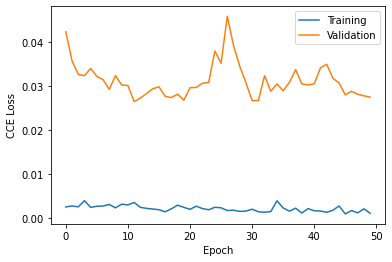

In [14]:
if buildEnv: 
    print( history.history.keys() )
    print( allLoss )
    plt.plot( allLoss )
    plt.plot( valLoss )
    plt.legend(['Training','Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('CCE Loss')
    #plt.ylim([0,1])
    plt.show()



In [15]:
if buildEnv: 
    
    pTestScores = model.predict( Xval )
    pTrainScores = model.predict( X )

    print( Y.shape, Yval.shape )
    print( pTestScores.shape, pTrainScores.shape )

    trainCorr = np.corrcoef(  Y[:,0], pTrainScores[:,0] )[0,1]
    testCorr = np.corrcoef(  Yval[:,0], pTestScores[:,0] )[0,1]
    print( trainCorr, testCorr )

(252, 1) (63, 1)
(63, 1) (252, 1)
0.9861290997597737 0.7367545157762058


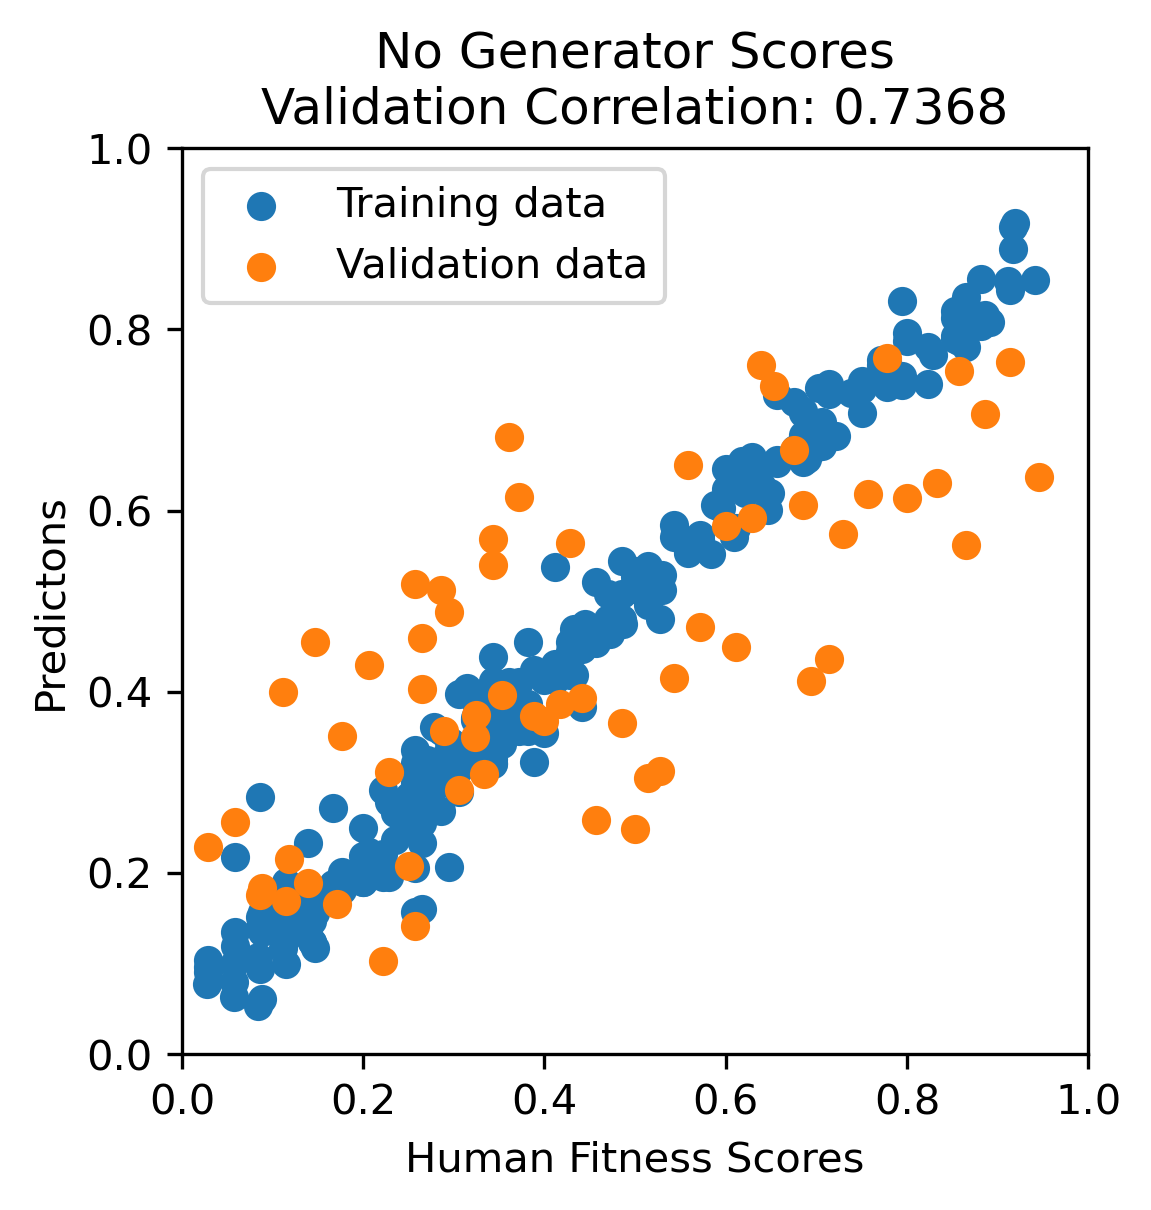

In [16]:


if buildEnv: 

    plt.figure(figsize=(4,4), dpi=300)
    plt.scatter( Y[:,0], pTrainScores, label='Training data' ) 
    plt.scatter( Yval[:,0], pTestScores, label='Validation data' )
    
    plt.xlabel('Human Fitness Scores')
    plt.ylabel('Predictons')
    plt.title("No Generator Scores\nValidation Correlation: %.4f"% testCorr)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend()

    plt.gca().set_aspect('equal')


# Continue Training?

In [26]:
with strategy.scope():
    
    if buildEnv: 
    
        scale = 1.0
        print( 'LR Before: %f' % args.learning_rate )
        args.learning_rate *= scale
        print("LR After: % ", args.learning_rate )
        keras.backend.set_value( 
            model.optimizer.learning_rate, 
            float( args.learning_rate ) 
        )

        history = model.fit(
           dg_trainer,
            validation_data = ( Xval, Yval ),
            epochs     = args.num_epochs,
            verbose    = args.verbose,
        )

        # Save loss
        allLoss = np.append( allLoss, history.history['loss'] )
        valLoss = np.append( valLoss, history.history['val_loss'] ) 

        if args.save_model: 
            model.save( 'models/%s-%s-%s.h5' % (args.runName, str(timeid), str(i)), save_format='h5' )

        with open( 'results/%s.txt' % args.runName, 'a' ) as f: 

            print( 'Progress: %d - %d' % ( i, timeid ), file=f )
            print( "Validation accuracy:",*["%.8f"%(x) for x in history.history['loss']], file=f)    
            print( "Test accuracy:",*["%.8f"%(x) for x in history.history['val_loss']],file=f)


LR Before: 0.000100
LR After: %  0.0001
Epoch 1/50
16/16 [==============================] - 1s 59ms/step - loss: 0.0014 - val_loss: 0.0270
Epoch 2/50
16/16 [==============================] - 1s 60ms/step - loss: 0.0022 - val_loss: 0.0315
Epoch 3/50
16/16 [==============================] - 1s 61ms/step - loss: 0.0024 - val_loss: 0.0373
Epoch 4/50
16/16 [==============================] - 1s 57ms/step - loss: 0.0019 - val_loss: 0.0304
Epoch 5/50
16/16 [==============================] - 1s 56ms/step - loss: 0.0017 - val_loss: 0.0248
Epoch 6/50
16/16 [==============================] - 1s 59ms/step - loss: 0.0014 - val_loss: 0.0234
Epoch 7/50
16/16 [==============================] - 1s 61ms/step - loss: 0.0016 - val_loss: 0.0283
Epoch 8/50
16/16 [==============================] - 1s 58ms/step - loss: 0.0024 - val_loss: 0.0281
Epoch 9/50
16/16 [==============================] - 1s 60ms/step - loss: 0.0012 - val_loss: 0.0296
Epoch 10/50
16/16 [==============================] - 1s 58ms/step - l

# Save Model?

In [30]:
   
if buildEnv: 
    if False:
        model.save( 'models/blah_11-22-0.h5' , save_format='h5' )

    with open( 'results/%s.txt' % args.runName , 'w' ) as f: 

        print( 'Progress: %d - %d' % ( i, timeid ), file=f )
        print( "Validation accuracy:",*["%.8f"%(x) for x in allLoss], file=f)    
        print( "Test accuracy:",*["%.8f"%(x) for x in valLoss],file=f)

        
print("Saved")

Saved
